# Natural Language Processing 2024 – Ex. 2

**Add the names and ID of the submitting students here:**

Liron Farzam 


In this exercise we will perform the task of Sentiment analysis over the IMDB movie review dataset.

The dataset has around 50K movie reviews with each review labeled as "positive" or "negative".

Our goal is given the review we want to classifiy it as positive or negative, this task is also called "Sentiment Analysis"

Below you can find a suggestion of the order things should be implemented, you can follow this or do it your own way.

The exercise has several stages:

1. Downloading and cleaning the data
2. Running some basic analysis
3. Training a Feed Forward network to perform the task using classification
4. Training a Bi-Dir LSTM to perform the task
5. Playing with paramters to see if we get better results

Please sumbit the notebook after it's running stage. Grade will be given for clean code, with comments and explanations

In [1]:
try:
    # Import necessary libraries
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import time
    import re
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    import torch.nn.functional as F
    from sklearn.metrics import accuracy_score, confusion_matrix
    import seaborn as sns
    from IPython.display import Audio
    from bs4 import BeautifulSoup
    from wordcloud import WordCloud
    from sklearn.feature_extraction.text import CountVectorizer
    from collections import Counter
    from sklearn.model_selection import train_test_split

    # NLTK imports
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    from nltk import bigrams, FreqDist

except ImportError as e:
    print('\033[93m' + str(e) + '\033[0m')
    print('\033[93m' + 'Please install the missing libraries' + '\033[0m')
    exit()


# Filter only the reviews that are less than or equal to 500 words and save the label as well
MAX_LENGTH = 500

# Define constants
INPUT_SIZE = MAX_LENGTH  # Adjust if needed
HIDDEN_SIZE1 = 128
HIDDEN_SIZE2 = 64
HIDDEN_SIZE3 = 64
HIDDEN_SIZE4 = 32
OUTPUT_SIZE = 1  # Binary classification
LEARNING_RATE = 0.0001
EPOCHS = 20
BATCH_SIZE = 128

IN_GOOGLE_COLAB = False

if IN_GOOGLE_COLAB:
    path_for_IMDB_Dataset = '/content/drive/MyDrive/IMDB Dataset.csv'
    path_for_glove = "/content/drive/MyDrive/glove.6B.100d.word2vec.txt"
else:
    path_for_IMDB_Dataset = './IMDB Dataset.csv'
    path_for_glove = "./glove.6B.100d.word2vec.txt"



def beep():
    # Define the beep parameters
    duration = 0.20  # Duration of the beep in seconds
    frequency = 1250  # Frequency of the beep in Hz

    # Generate the beep sound
    t = np.linspace(0, duration, int(duration * 44100), endpoint=False)
    beep_signal = np.cos(2 * np.pi * frequency * t)

    # Play the beep sound
    Audio(beep_signal, rate=44100, autoplay=True)

beep()

# Data download and cleaning

1. Download the IMDB dataset.

2. Clean the data:
* Remove URLs, HTML tags and non-alphanumeric characters
* Remove stop-words (use NLTK)
* Lowercase the dataset
* (Optional) Anything else you think can help...

Show one example of a review before and after this cleaning (find a review which has at least one URL/HTML tag/Non-aplhanumeric characters)



In [2]:
if IN_GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

In [3]:
try:
    df = pd.read_csv(path_for_IMDB_Dataset)
    df2 = df.copy()
    print('\033[92m' + 'Success to Read CSV file' + '\033[0m')
except:
    print('\033[91m' + 'Failed to Read CSV file' + '\033[0m')

# Data Preprocessing
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

def convert_numbers(text):
    return re.sub(r'\d+', '<digit>', text)

def remove_non_alphabetic_characters(text):
    clean = re.compile('[^a-zA-Z]')
    return re.sub(clean, ' ', text)

def convert_to_lower_case(text):
    return text.lower()

def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    words = [ps.stem(word) for word in words]
    return ' '.join(words)

def drop_one_latter_words(text):
    words = text.split()
    words = [word for word in words if len(word) > 1]
    return ' '.join(words)



df['review'] = df['review'].apply(convert_to_lower_case)
print('\033[92m' + 'Success to convert to lower case' + '\033[0m')
df['review'] = df['review'].apply(remove_html_tags)
print('\033[92m' + 'Success to remove HTML tags' + '\033[0m')
df['review'] = df['review'].apply(remove_non_alphabetic_characters)
print('\033[92m' + 'Success to remove non-alphabetic characters' + '\033[0m')
df['review'] = df['review'].apply(drop_one_latter_words)
print('\033[92m' + 'Success to remove one letter words' + '\033[0m')



# df['review'] = df['review'].apply(convert_numbers)
# print('\033[92m' + 'Success to convert numbers' + '\033[0m')

# df['review'] = df['review'].apply(remove_stop_words)
# print('\033[92m' + 'Success to remove stop words' + '\033[0m')
# df['review'] = df['review'].apply(stemming)
# print('\033[92m' + 'Success to apply stemming' + '\033[0m')


beep()

# Print the first 3 rows of the dataset
for i in range(3):
    print(df2['review'][i])
    print('-' * 50)
    print(df['review'][i])
    print('=' * 50)


Success to Read CSV file
Success to convert to lower case


/Users/lfarz/opt/anaconda3/envs/tf/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Success to remove HTML tags
Success to remove non-alphabetic characters
Success to remove one letter words
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings an

# Tokenization

1. Tokenize the dataset (you can tokenize using spaces or use more robust methods from NLTK)
2. (Optional) Lemmatize the text (you can use NLTK) this can improve results
3. Show an example of 3 sentences before and after this process

In [4]:
# Step 2: Tokenization

df2 = df.copy()

def tokenize(text):
    return nltk.word_tokenize(text)

df['review'] = df['review'].apply(tokenize)
print('\033[92m' + 'Success to tokenize' + '\033[0m')


def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text
    words = [word for word in words if word not in stop_words]
    return words

df['review'] = df['review'].apply(remove_stop_words)
print('\033[92m' + 'Success to remove stop words' + '\033[0m')


def drop_duplicates(df):
    df['review'] = df['review'].apply(lambda x: ' '.join(x))
    df = df.drop_duplicates()
    return df

df = drop_duplicates(df)
print('\033[92m' + 'Success to drop duplicates' + '\033[0m')


def lemmatize(text):
    lemmatizer = nltk.WordNetLemmatizer()
    return lemmatizer.lemmatize(text)

df['review'] = df['review'].apply(lemmatize)
print('\033[92m' + 'Success to lemmatize' + '\033[0m')

beep()

# Print the first 3 rows of the dataset
for i in range(3):
    print(df2['review'][i])
    print('-' * 50)
    print(df['review'][i])
    print('=' * 50)


Success to tokenize
Success to remove stop words
Success to drop duplicates
Success to lemmatize
one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal

# Basic analysis

Perfrom some analysis on the data
1. Show the number percentage of negative/positive review (label balancing)
2. Plot some statistics on the length of review (after our cleaning process)
3. (Optional) show anything else you think is important

1. Ratio of division between positive and negative:
Number of Positive Reviews: 25000 (50.00%)
Number of Negative Reviews: 25000 (50.00%)


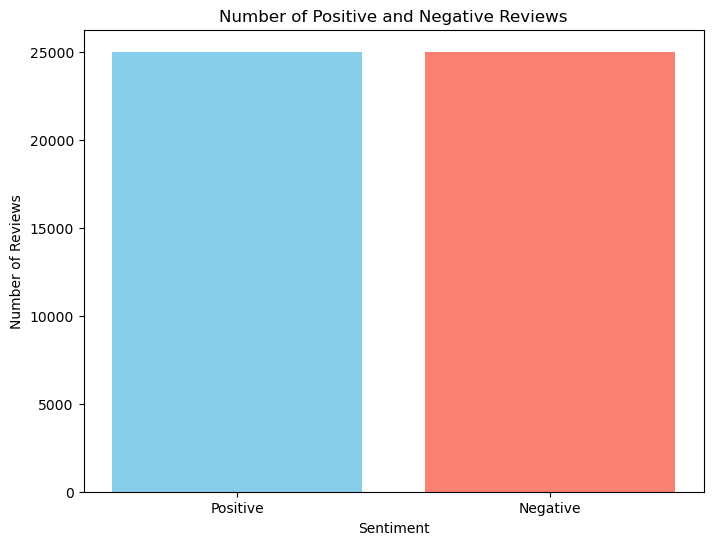

######################################################################################################################################################
2. Statistics on the length of reviews:


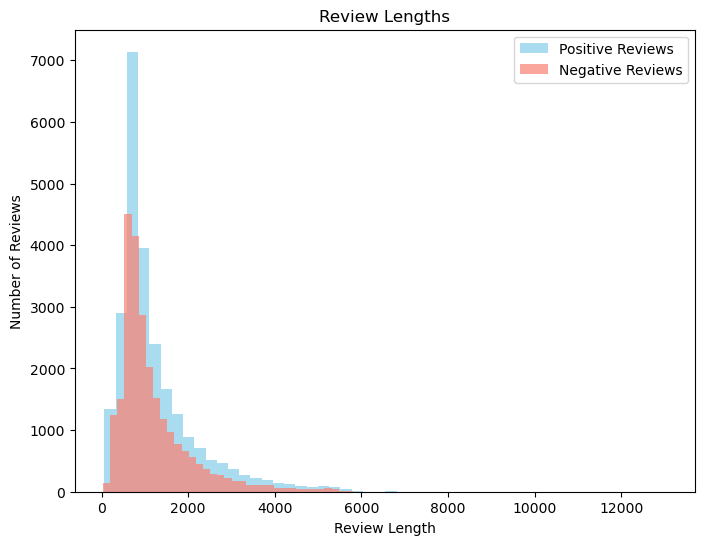

######################################################################################################################################################
3. Statistics on the unique word count of reviews:


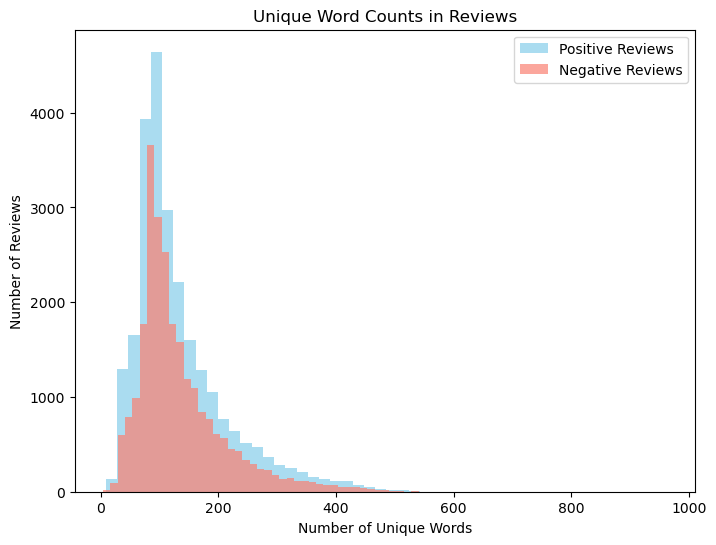

######################################################################################################################################################
4. Average length of positive and negative reviews:
Average Length of Positive Reviews: 1236.16
Average Length of Negative Reviews: 1201.91
######################################################################################################################################################
5. Most common words in positive and negative reviews:
Most Common Words in Positive Reviews:
the     341202
and     176593
of      152091
to      131303
is      111818
in       99228
it       95117
this     69614
that     69579
as       51111
dtype: int64

Most Common Words in Negative Reviews:
the     326542
and     147774
of      137292
to      136774
is       99245
it       95696
in       87507
this     81307
that     74270
was      52256
dtype: int64
##################################################################################################

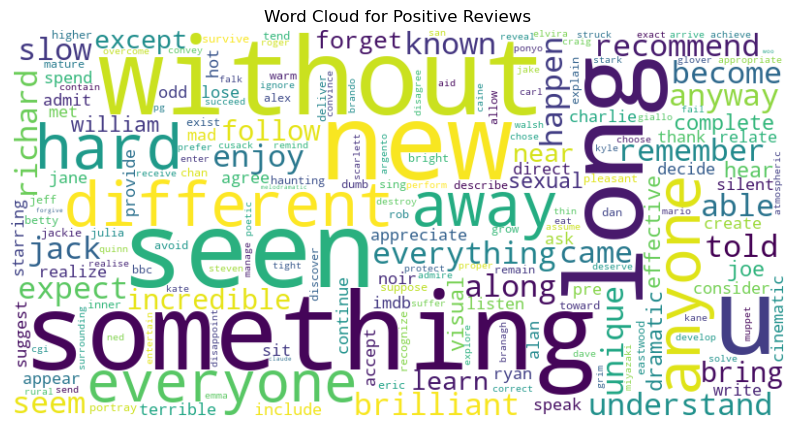

######################################################################################################################################################


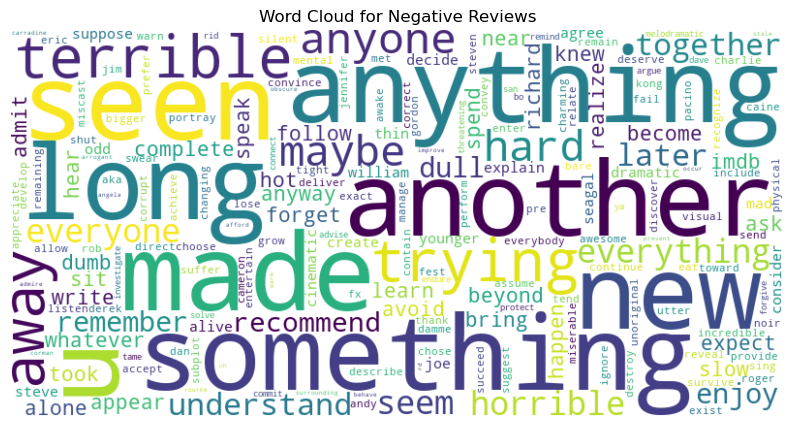

######################################################################################################################################################
9. Bigrams Analysis:
Most Common Bigrams in Positive Reviews (after filtering stop words):
[(('one', 'best'), 1680), (('even', 'though'), 1099), (('ever', 'seen'), 977), (('first', 'time'), 960), (('new', 'york'), 854), (('special', 'effects'), 806), (('see', 'movie'), 784), (('must', 'see'), 777), (('real', 'life'), 760), (('years', 'ago'), 741)]

Most Common Bigrams in Negative Reviews (after filtering stop words):
[(('ever', 'seen'), 1731), (('special', 'effects'), 1443), (('waste', 'time'), 1434), (('looks', 'like'), 1235), (('low', 'budget'), 1228), (('much', 'better'), 1008), (('one', 'worst'), 964), (('look', 'like'), 944), (('bad', 'movie'), 924), (('year', 'old'), 915)]

######################################################################################################################################################


In [5]:
# Basic Analysis

# 1. Extract sentiment-specific data
print('\033[92m' + '1. Ratio of division between positive and negative:' + '\033[0m')

positive_reviews = df2[df2['sentiment'] == 'positive']['review']
negative_reviews = df2[df2['sentiment'] == 'negative']['review']
all_reviews = df2['sentiment']

# Count number of reviews and their percentages
num_positive_reviews = len(positive_reviews)
num_negative_reviews = len(negative_reviews)
total_reviews = len(df2)

percentage_positive = (num_positive_reviews / total_reviews) * 100
percentage_negative = (num_negative_reviews / total_reviews) * 100

# Display number and percentage of positive and negative reviews
print(f"Number of Positive Reviews: {num_positive_reviews} ({percentage_positive:.2f}%)")
print(f"Number of Negative Reviews: {num_negative_reviews} ({percentage_negative:.2f}%)")

# Plot the number of positive and negative reviews
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [num_positive_reviews, num_negative_reviews], color=['skyblue', 'salmon'])
plt.title('Number of Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()
print("#" * 150)

# 2. Calculate and display statistics on the length of reviews
print('\033[92m' + '2. Statistics on the length of reviews:' + '\033[0m')

positive_review_lengths = positive_reviews.apply(len)
negative_review_lengths = negative_reviews.apply(len)

plt.figure(figsize=(8, 6))
plt.hist(positive_review_lengths, bins=50, color='skyblue', alpha=0.7, label='Positive Reviews')
plt.hist(negative_review_lengths, bins=50, color='salmon', alpha=0.7, label='Negative Reviews')
plt.title('Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()
print("#" * 150)

# 3. Calculate and display statistics on the unique word count of reviews
print('\033[92m' + '3. Statistics on the unique word count of reviews:' + '\033[0m')

positive_unique_word_counts = positive_reviews.apply(lambda x: len(set(x.split())))
negative_unique_word_counts = negative_reviews.apply(lambda x: len(set(x.split())))

plt.figure(figsize=(8, 6))
plt.hist(positive_unique_word_counts, bins=50, color='skyblue', alpha=0.7, label='Positive Reviews')
plt.hist(negative_unique_word_counts, bins=50, color='salmon', alpha=0.7, label='Negative Reviews')
plt.title('Unique Word Counts in Reviews')
plt.xlabel('Number of Unique Words')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()
print("#" * 150)



# 4. Calculate and display the average length of positive and negative reviews
print('\033[92m' + '4. Average length of positive and negative reviews:' + '\033[0m')

avg_positive_length = positive_review_lengths.mean()
avg_negative_length = negative_review_lengths.mean()

print(f"Average Length of Positive Reviews: {avg_positive_length:.2f}")
print(f"Average Length of Negative Reviews: {avg_negative_length:.2f}")
print("#" * 150)

# 5. Show the most common words in positive and negative reviews
print('\033[92m' + '5. Most common words in positive and negative reviews:' + '\033[0m')

def get_most_common_words(reviews):
    reviews = reviews.apply(lambda x: x.split())
    return reviews.apply(pd.Series).stack().value_counts()

# Display most common words in positive reviews
positive_common_words = get_most_common_words(positive_reviews)
print("Most Common Words in Positive Reviews:")
print(positive_common_words.head(10))
print()

# Display most common words in negative reviews
negative_common_words = get_most_common_words(negative_reviews)
print("Most Common Words in Negative Reviews:")
print(negative_common_words.head(10))
print("#" * 150)

# 6. Show the most common words in positive and negative reviews after removing stop words
print('\033[92m' + '6. Most common words in positive and negative reviews after removing stop words:' + '\033[0m')

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_get_common_words(reviews):
    reviews = reviews.apply(lambda x: x.split())
    reviews = reviews.apply(lambda x: [word for word in x if word not in stop_words])
    return reviews.apply(pd.Series).stack().value_counts()

# Display most common words in positive reviews after removing stop words
positive_common_words_no_stopwords = remove_stopwords_and_get_common_words(positive_reviews)
print("Most Common Words in Positive Reviews (After Removing Stop Words):")
print(positive_common_words_no_stopwords.head(10))
print()

# Display most common words in negative reviews after removing stop words
negative_common_words_no_stopwords = remove_stopwords_and_get_common_words(negative_reviews)
print("Most Common Words in Negative Reviews (After Removing Stop Words):")
print(negative_common_words_no_stopwords.head(10))
print("#" * 150)

# 7. Show the most common words in positive and negative reviews after removing stop words and lemmatization
print('\033[92m' + '7. Most common words in positive and negative reviews after removing stop words and lemmatization:' + '\033[0m')

lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_and_get_common_words(reviews):
    reviews = reviews.apply(lambda x: x.split())
    reviews = reviews.apply(lambda x: [word for word in x if word not in stop_words])
    reviews = reviews.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return reviews.apply(pd.Series).stack().value_counts()

# Display most common words in positive reviews after removing stop words and lemmatization
positive_common_words_lemmatized = lemmatize_and_get_common_words(positive_reviews)
print("Most Common Words in Positive Reviews (After Removing Stop Words and Lemmatization):")
print(positive_common_words_lemmatized.head(10))
print()

# Display most common words in negative reviews after removing stop words and lemmatization
negative_common_words_lemmatized = lemmatize_and_get_common_words(negative_reviews)
print("Most Common Words in Negative Reviews (After Removing Stop Words and Lemmatization):")
print(negative_common_words_lemmatized.head(10))
print("#" * 150)

# 8. Word Clouds
print('\033[92m' + '8. Word Clouds:' + '\033[0m')

def generate_word_cloud(text_series, title):
    # Concatenate the values in the Series into a single string
    text = ' '.join(text_series.index)

    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis('off')
    plt.show()


# Generate Word Cloud for Positive Reviews after removing stop words and lemmatization
generate_word_cloud(positive_common_words_lemmatized, 'Word Cloud for Positive Reviews')
print("#" * 150)

# Generate Word Cloud for Negative Reviews after removing stop words and lemmatization
generate_word_cloud(negative_common_words_lemmatized, 'Word Cloud for Negative Reviews')
print("#" * 150)

# 9. Bigrams Analysis: Most Common sequences of two adjacent words in positive and negative reviews
print('\033[92m' + '9. Bigrams Analysis:' + '\033[0m')

def get_most_common_bigrams_filtered(reviews):

    stop_words = set(stopwords.words('english'))
    # add "digit" to stop words
    stop_words.add('digit')

    reviews = reviews.apply(lambda x: [word for word in x.split() if word.lower() not in stop_words])
    bigram_list = list(bigrams(reviews.apply(pd.Series).stack()))
    bigram_freq = FreqDist(bigram_list)
    return bigram_freq

# Display most common bigrams in positive reviews after filtering stop words
positive_bigrams_filtered = get_most_common_bigrams_filtered(positive_reviews)
print("Most Common Bigrams in Positive Reviews (after filtering stop words):")
print(positive_bigrams_filtered.most_common(10))
print()

# Display most common bigrams in negative reviews after filtering stop words
negative_bigrams_filtered = get_most_common_bigrams_filtered(negative_reviews)
print("Most Common Bigrams in Negative Reviews (after filtering stop words):")
print(negative_bigrams_filtered.most_common(10))
print()
print("#" * 150)


# Preparing the dataset for training

1. Choose your vocabulary size K (should be between 1000 and 3000)
2. Find the top K frequent words in your database
3. Create word indexes like we did in class, for any word not in your top K  words replace with \<UNK\>. Remember to add an index for the \<PAD\> token.
4. Create a new dataset with indexes instead of words later to be used for training
5. Convert your labels to numeric representation (that your network can deal with).

Split the dataset to 80% traind and 20% test, remember to keep the balance between labels!



In [6]:
# Step 1: Choose vocabulary size K
VOCAB_SIZE = 2000

# Step 2: Find the most common K words in the dataset
# Combine all reviews into a single string

# Combine all reviews into a single list of words
all_words = df['review'].apply(lambda x: x.split())
all_words = all_words.apply(pd.Series).stack().reset_index(drop=True)

# Use Counter to count occurrences of each word
word_count = Counter(all_words)

# Get the most common words and their occurrences
print('\033[92m' + 'Most common words in the dataset and count of occurrences:' + '\033[0m')
print(word_count.most_common(15))
print("#" * 150)

# Step 3: Create a vocabulary dictionary with the most common K words and their indices
vocab = {}
vocab['<UNK>'] = 0
vocab['<PAD>'] = 1
for i, (word, count) in enumerate(word_count.most_common(VOCAB_SIZE - 2)):
    vocab[word] = i + 2

print('\033[92m' + 'Vocabulary dictionary with the most common K words:' + '\033[0m')
print(vocab)
print("#" * 150)

# Step 4: New dataset with the indices of the words in the vocabulary
def words_to_indices(words, vocab):
    return [vocab[word] if word in vocab else vocab['<UNK>'] for word in words]

df['review'] = df['review'].apply(lambda x: words_to_indices(x.split(), vocab))  # Split the string into words first

# Print the first 3 rows of the dataset and the decoded reviews
print('\033[92m' + 'New dataset with the indices of the words in the vocabulary:' + '\033[0m')
for i in range(3):
    print(df2['review'][i])
    print('-' * 50)
    print(df['review'][i])
    print('=' * 50)

print("#" * 150)

# Step 6: Split the dataset into training and testing sets (80% training, 20% testing but but maintains the ratio between positive and negative reviews)
X = df['review']
y = df['sentiment']

# Convert the Labels to 0 - negative and 1 - positive
y = y.map({'negative': 0, 'positive': 1})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the number of training and testing samples
print('\033[92m' + 'Number of training and testing samples:' + '\033[0m')
print(f"Number of Training Samples: {len(X_train)}")
print(f"Number of Testing Samples: {len(X_test)}")
#print the number of positive and negative reviews in the training and testing sets
print(f"Number of Positive Reviews in Training Set: {y_train.value_counts()[0]}")
print(f"Number of Negative Reviews in Training Set: {y_train.value_counts()[1]}")
print(f"Number of Positive Reviews in Testing Set: {y_test.value_counts()[0]}")
print(f"Number of Negative Reviews in Testing Set: {y_test.value_counts()[1]}")
print("#" * 150)


Most common words in the dataset and count of occurrences:
[('movie', 87226), ('film', 79117), ('one', 53181), ('like', 39828), ('good', 29523), ('time', 24894), ('even', 24647), ('would', 24397), ('story', 22960), ('really', 22916), ('see', 22812), ('well', 21096), ('much', 19147), ('bad', 18276), ('get', 18266)]
######################################################################################################################################################
Vocabulary dictionary with the most common K words:
{'<UNK>': 0, '<PAD>': 1, 'movie': 2, 'film': 3, 'one': 4, 'like': 5, 'good': 6, 'time': 7, 'even': 8, 'would': 9, 'story': 10, 'really': 11, 'see': 12, 'well': 13, 'much': 14, 'bad': 15, 'get': 16, 'people': 17, 'great': 18, 'also': 19, 'first': 20, 'made': 21, 'make': 22, 'way': 23, 'could': 24, 'movies': 25, 'characters': 26, 'think': 27, 'watch': 28, 'character': 29, 'films': 30, 'two': 31, 'many': 32, 'seen': 33, 'love': 34, 'never': 35, 'plot': 36, 'life': 37, 'acting': 3

# Training a feed forward neural network

For simplicity we would take only reviews with 500 words (after tokenization) or less.
For this part we would train a neural network that gets the full review as one input (like we had in our NER example in class) and outputs the label (positive or negative).
Remember that you need to PAD the words so all reviews will have the same length.

For this section please try at least 3 variants of different network and show if the results change, you can choose from the following:
1. Adding hidden layers to the network
2. Running with and without Dropout
3. Trying different optimizers

(Optional) Try to use the Glove embedding: Create an embedding layer in your PyTorch model using the loaded GloVe embeddings. You will initialize the weights of the embedding layer with the GloVe embeddings.

For each option:

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

In [7]:
# Filter training set
filtered_train_data = [(x, y) for x, y in zip(X_train, y_train) if len(x) <= MAX_LENGTH]
X_train, y_train = zip(*filtered_train_data)

# Filter testing set
filtered_test_data = [(x, y) for x, y in zip(X_test, y_test) if len(x) <= MAX_LENGTH]
X_test, y_test = zip(*filtered_test_data)


# Print the number of training and testing samples after filtering
print('\033[92m' + 'Number of training and testing samples after filtering:' + '\033[0m')
print(f"Number of Training Samples: {len(X_train)}")
print(f"Number of Positive Reviews in Training Set: {y_train.count(0)}")
print(f"Number of Negative Reviews in Training Set: {y_train.count(1)}")
print(f"Number of Testing Samples: {len(X_test)}")
print(f"Number of Positive Reviews in Testing Set: {y_test.count(0)}")
print(f"Number of Negative Reviews in Testing Set: {y_test.count(1)}")
print("#" * 150)

# print the 10 first reviews in the training set and their labels
print('\033[92m' + 'First 5 reviews in the training set and their labels:' + '\033[0m')
for i in range(5):
    print(X_train[i], y_train[i])
print("#" * 150)

print('\033[92m' + 'First 5 reviews in the testing set and their labels:' + '\033[0m')
for i in range(5):
    print(X_test[i], y_test[i])
print("#" * 150)


# Pad the sequences to have a length of 500
X_train = [x + [vocab['<PAD>']] * (MAX_LENGTH - len(x)) for x in X_train]
X_test = [x + [vocab['<PAD>']] * (MAX_LENGTH - len(x)) for x in X_test]

# print the 10 first reviews in the training set and their labels
print('\033[92m' + 'First 5 reviews in the training set and their labels after padding:' + '\033[0m')
for i in range(5):
    print(X_train[i], y_train[i])
print("#" * 150)

print('\033[92m' + 'First 5 reviews in the testing set and their labels after padding:' + '\033[0m')
for i in range(5):
    print(X_test[i], y_test[i])
print("#" * 150)


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Number of training and testing samples after filtering:
Number of Training Samples: 39456
Number of Positive Reviews in Training Set: 19680
Number of Negative Reviews in Training Set: 19776
Number of Testing Samples: 9864
Number of Positive Reviews in Testing Set: 4919
Number of Negative Reviews in Testing Set: 4945
######################################################################################################################################################
First 5 reviews in the training set and their labels:
[0, 15, 900, 0, 245, 0, 0, 3, 0, 0, 678, 214, 985, 1001, 0, 1683, 1717, 0, 0, 1173, 0, 0, 0, 987, 0, 0, 0, 644, 0, 0, 0, 0, 252, 0, 0, 0, 0, 284, 0, 0, 248, 179, 1130, 150, 0, 19, 475, 0, 150, 3, 196, 313, 0, 631, 382, 32, 0, 109] 1
[672, 3, 137, 0, 1055, 0, 610, 0, 53, 225, 1465, 225, 69, 13, 70, 69, 463, 610, 307, 55, 131, 110, 371, 80, 11, 157, 0, 64, 6, 92, 131, 0, 45, 116, 1772, 42, 78, 98, 5, 393, 175, 0, 1917, 0, 0, 27, 265, 1430, 0, 238, 598, 42, 78, 238] 0
[137, 0

In [8]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=10, device='cpu'):
    train_losses = []
    test_losses = []
    all_labels = []
    all_predictions = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        start = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Remove .long() conversion
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Remove .long() conversion
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                test_loss += loss.item()
                predicted = torch.round(outputs)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect labels and predictions for confusion matrix
                all_labels.extend(labels.tolist())
                all_predictions.extend(predicted.tolist())

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Test Accuracy: {(correct / total) :.2f}%',
              f'Time: {time.time() - start:.2f} sec')

    # Plot training and testing errors
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Errors')
    plt.legend()
    plt.show()

    # Evaluate final results
    print('\033[92m' + 'Final Results:' + '\033[0m')
    print(f'Test Accuracy: {(correct / total) * 100:.2f}%')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Simple Neural Network:
SimpleNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)
######################################################################################################################################################
Epoch 1/20, Train Loss: 0.0413, Test Loss: 0.0141, Test Accuracy: 63.98% Time: 0.83 sec
Epoch 2/20, Train Loss: 0.0093, Test Loss: 0.0081, Test Accuracy: 64.05% Time: 0.73 sec
Epoch 3/20, Train Loss: 0.0066, Test Loss: 0.0067, Test Accuracy: 63.94% Time: 0.70 sec
Epoch 4/20, Train Loss: 0.0058, Test Loss: 0.0063, Test Accuracy: 63.93% Time: 0.73 sec
Epoch 5/20, Train Loss: 0.0055, Test Loss: 0.0061, Test Accuracy: 64.01% Time: 0.73 sec
Epoch 6/20, Train Loss: 0.0054, Test Loss: 0.0060, Test Accuracy: 63.95% Time: 0.66 sec
Epoch 7/20, Train Loss: 0.0053, Test Loss: 0.0060, Test Accuracy: 

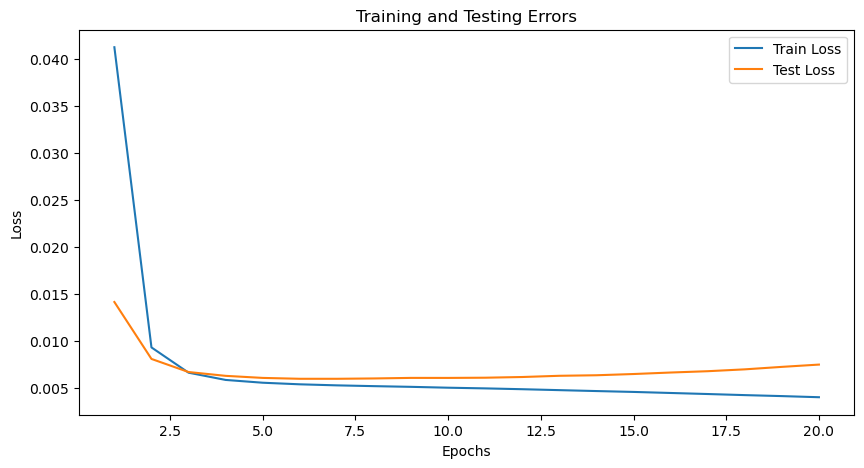

Final Results:
Test Accuracy: 6400.91%


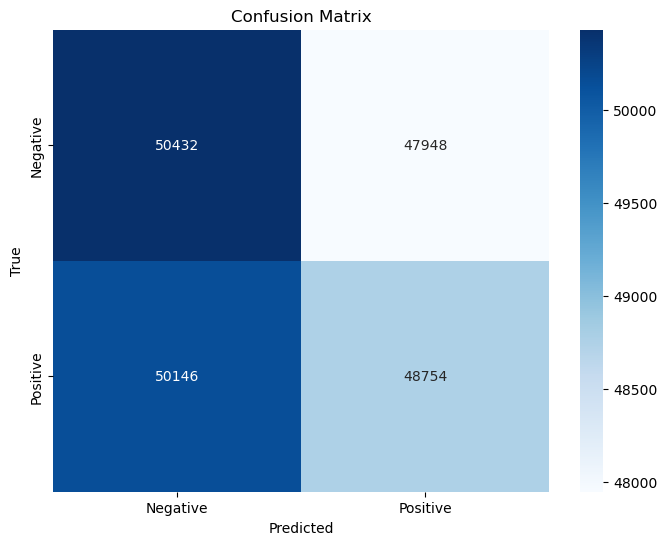

######################################################################################################################################################
Neural Network whit 2 hidden layers:
NN2HiddenLayers(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
######################################################################################################################################################
Epoch 1/20, Train Loss: 0.0295, Test Loss: 0.0110, Test Accuracy: 63.86% Time: 0.77 sec
Epoch 2/20, Train Loss: 0.0086, Test Loss: 0.0077, Test Accuracy: 63.81% Time: 0.72 sec
Epoch 3/20, Train Loss: 0.0065, Test Loss: 0.0066, Test Accuracy: 63.84% Time: 0.72 sec
Epoch 4/20, Train Loss: 0.0058, Test Loss: 0.0062, Test Accuracy: 63.95% Time: 0.71 sec
Epoch 5/20, Train Loss: 0.0055, Test Loss: 0.0061, Test Accuracy

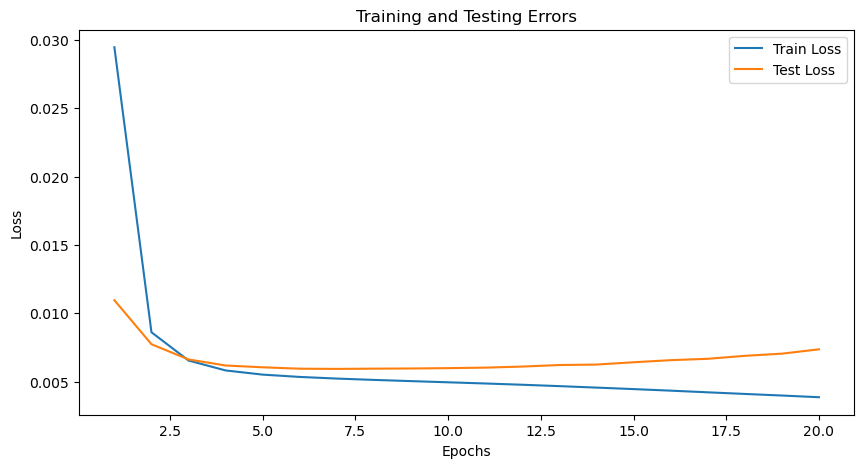

Final Results:
Test Accuracy: 6384.37%


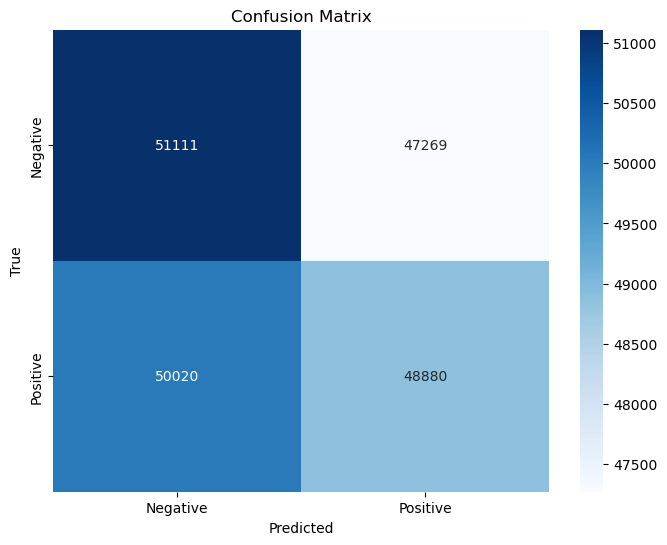

######################################################################################################################################################
Neural Network whit 4 hidden layers:
NN4HiddenLayers(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)
######################################################################################################################################################
Epoch 1/20, Train Loss: 0.0061, Test Loss: 0.0057, Test Accuracy: 64.02% Time: 1.03 sec
Epoch 2/20, Train Loss: 0.0055, Test Loss: 0.0057, Test Accuracy: 64.01% Time: 0.97 sec
Epoch 3/20, Train Loss: 0.0053, Test Loss: 0.0057, Test Accuracy: 63.98% Time: 0.87 sec
Epoch 4/20, Train Loss: 0.0052, 

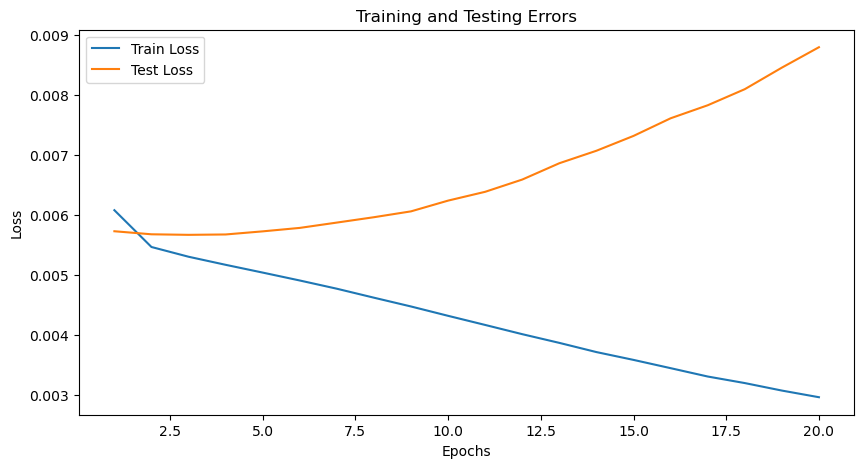

Final Results:
Test Accuracy: 6396.57%


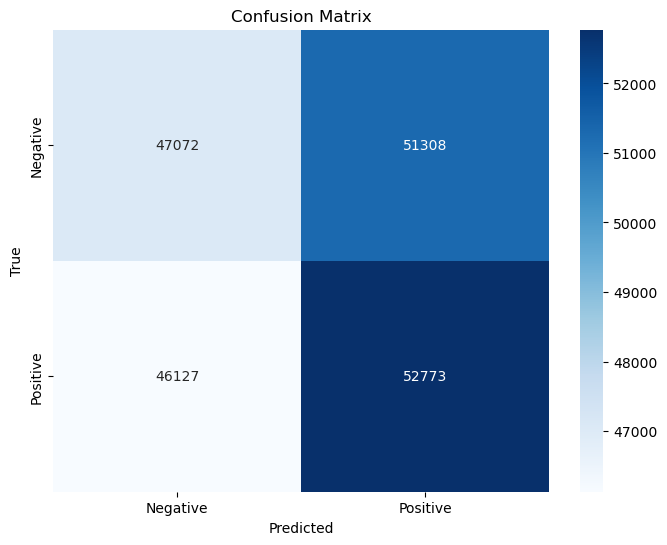

######################################################################################################################################################
Neural Network whit 4 hidden layers and Dropout:
NN4HiddenLayersDropout(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
######################################################################################################################################################
Epoch 1/20, Train Loss: 0.0318, Test Loss: 0.0056, Test Accuracy: 63.86% Time: 1.06 sec
Epoch 2/20, Train Loss: 0.0081, Test Loss: 0.0055, Test Accuracy: 63.79% Time: 1.04 sec
Epoch 3/20, Train Loss: 0.0065, Test Loss: 0.0055, Test Ac

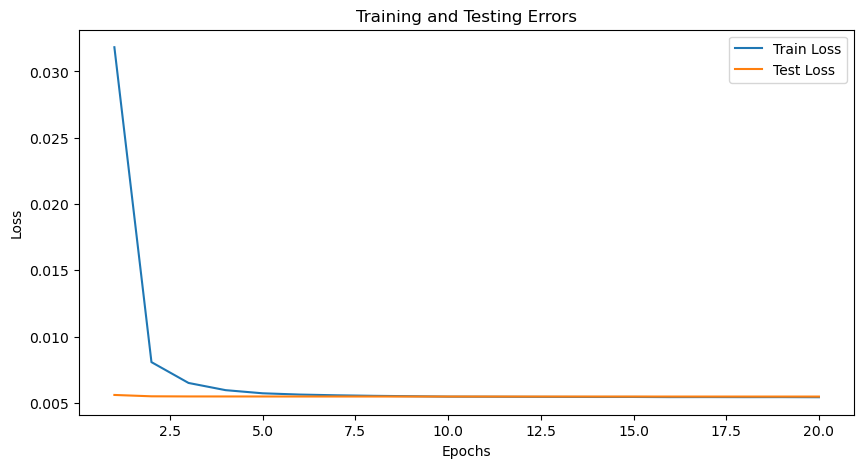

Final Results:
Test Accuracy: 6377.25%


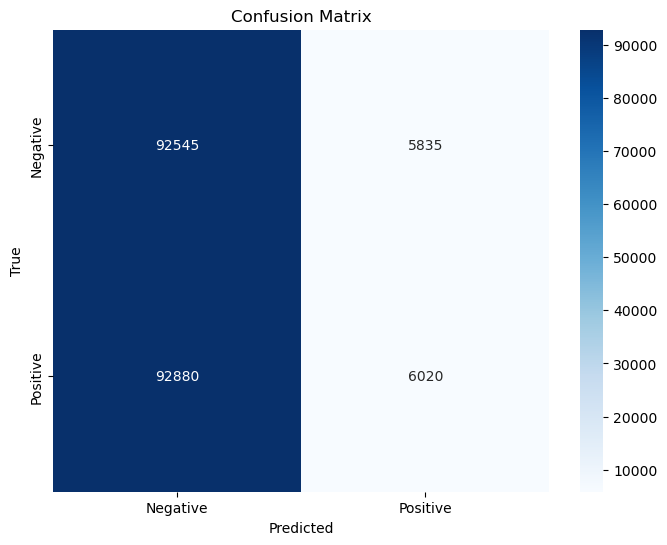

######################################################################################################################################################
Neural Network whit 4 hidden layers and different optimizers:
NN4HiddenLayersDifferentOptimizers(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)
######################################################################################################################################################
Epoch 1/20, Train Loss: 0.0085, Test Loss: 0.0067, Test Accuracy: 64.03% Time: 1.11 sec
Epoch 2/20, Train Loss: 0.0063, Test Loss: 0.0062, Test Accuracy: 64.00% Time: 0.81 sec
Epoch 3/20, Train Loss: 0.0060, Test Loss: 0.0060, Test Accuracy: 64.05% Tim

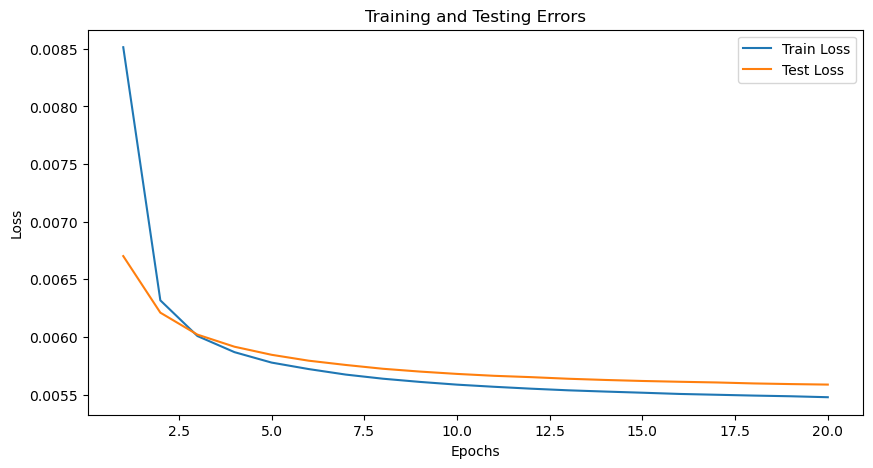

Final Results:
Test Accuracy: 6401.62%


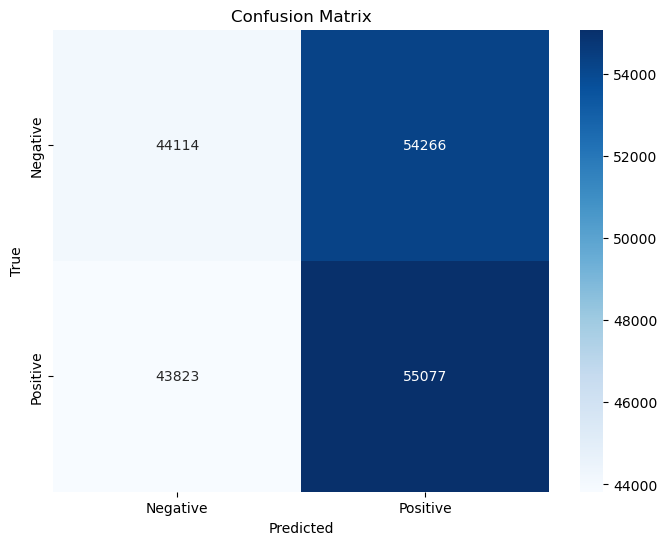

######################################################################################################################################################


In [9]:
print('\033[92m' + 'Simple Neural Network:' + '\033[0m')

# Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        layer_sizes = zip(hidden_sizes[:-1], hidden_sizes[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for linear in self.hidden_layers:
            x = torch.nn.functional.relu(linear(x))
        x = self.output(x)
        return torch.sigmoid(x)
    

# Define the sizes of the hidden layers
hidden_sizes = [HIDDEN_SIZE1, HIDDEN_SIZE2]
# Initialize the model
simple_model = SimpleNN(INPUT_SIZE, hidden_sizes, OUTPUT_SIZE)
# Loss and optimizer binary cross entropy loss and Adam optimizer
simple_criterion = nn.BCELoss()
simple_optimizer = optim.Adam(simple_model.parameters(), lr=LEARNING_RATE)
# Print the model architecture
print(simple_model)
print("#" * 150)
# Train and evaluate the model
train_and_evaluate(simple_model, train_loader, test_loader, simple_optimizer, simple_criterion, epochs=EPOCHS)
print("#" * 150)

#######################################################################################################################

print('\033[92m' + 'Neural Network whit 2 hidden layers:' + '\033[0m')

class NN2HiddenLayers(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN2HiddenLayers, self).__init__()

        # Define the input size of the network
        self.input_size = input_size

        # Define the list to hold the hidden layers
        self.hidden_layers = nn.ModuleList()

        # Add the first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Add the second hidden layer
        self.hidden_layers.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))

        # Define the output layer
        self.output_layer = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        # Flatten the input tensor if needed
        x = x.view(-1, self.input_size)

        # Pass the input through the hidden layers with ReLU activation
        for hidden_layer in self.hidden_layers:
            x = nn.functional.relu(hidden_layer(x))

        # Pass the output through the output layer with sigmoid activation
        x = nn.functional.sigmoid(self.output_layer(x))

        return x
    

# Define the sizes of the hidden layers
hidden_sizes = [HIDDEN_SIZE1, HIDDEN_SIZE2]
# Initialize the model
model_2_hidden_layers = NN2HiddenLayers(INPUT_SIZE, hidden_sizes, OUTPUT_SIZE)
# Loss and optimizer binary cross entropy loss and Adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_2_hidden_layers.parameters(), lr=LEARNING_RATE)
# Print the model architecture
print(model_2_hidden_layers)
print("#" * 150)
# Train and evaluate the model
train_and_evaluate(model_2_hidden_layers, train_loader, test_loader, optimizer, criterion, epochs=EPOCHS)
print("#" * 150)


#######################################################################################################################


print('\033[92m' + 'Neural Network whit 4 hidden layers:' + '\033[0m')

class NN4HiddenLayers(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN4HiddenLayers, self).__init__()

        # Define the input size of the network
        self.input_size = input_size

        # Define the list to hold the hidden layers
        self.hidden_layers = nn.ModuleList()

        # Add the first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Add subsequent hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        # Define the output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # Flatten the input tensor if needed
        x = x.view(-1, self.input_size)

        # Pass the input through the hidden layers with ReLU activation
        for hidden_layer in self.hidden_layers:
            x = nn.functional.relu(hidden_layer(x))

        # Pass the output through the output layer with sigmoid activation
        x = nn.functional.sigmoid(self.output_layer(x))

        return x

    

# Define the sizes of the hidden layers
hidden_sizes = [HIDDEN_SIZE1, HIDDEN_SIZE2, HIDDEN_SIZE3, HIDDEN_SIZE4]
# Initialize the model
model_4_hidden_layers = NN4HiddenLayers(INPUT_SIZE, hidden_sizes, OUTPUT_SIZE)
# Loss and optimizer binary cross entropy loss and Adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_4_hidden_layers.parameters(), lr=LEARNING_RATE)
# Print the model architecture
print(model_4_hidden_layers)
print("#" * 150)
# Train and evaluate the model
train_and_evaluate(model_4_hidden_layers, train_loader, test_loader, optimizer, criterion, epochs=EPOCHS)
print("#" * 150)

#######################################################################################################################


print('\033[92m' + 'Neural Network whit 4 hidden layers and Dropout:' + '\033[0m')

class NN4HiddenLayersDropout(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate):
        super(NN4HiddenLayersDropout, self).__init__()

        # Define the input size of the network
        self.input_size = input_size

        # Define the list to hold the hidden layers
        self.hidden_layers = nn.ModuleList()

        # Add the first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Add subsequent hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        # Define the output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        # Define the dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Flatten the input tensor if needed
        x = x.view(-1, self.input_size)

        # Pass the input through the hidden layers with ReLU activation and dropout
        for hidden_layer in self.hidden_layers:
            x = nn.functional.relu(hidden_layer(x))
            x = self.dropout(x)

        # Pass the output through the output layer with sigmoid activation
        x = nn.functional.sigmoid(self.output_layer(x))

        return x



# Define the sizes of the hidden layers
hidden_sizes = [HIDDEN_SIZE1, HIDDEN_SIZE2, HIDDEN_SIZE3, HIDDEN_SIZE4]
# Define the dropout rate
dropout = 0.5
# Initialize the model
model_4_hidden_layers_dropout = NN4HiddenLayersDropout(INPUT_SIZE, hidden_sizes, OUTPUT_SIZE, dropout)
# Loss and optimizer binary cross entropy loss and Adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_4_hidden_layers_dropout.parameters(), lr=LEARNING_RATE)
# Print the model architecture
print(model_4_hidden_layers_dropout)
print("#" * 150)
# Train and evaluate the model
train_and_evaluate(model_4_hidden_layers_dropout, train_loader, test_loader, optimizer, criterion, epochs=EPOCHS)
print("#" * 150)

#######################################################################################################################


print('\033[92m' + 'Neural Network whit 4 hidden layers and different optimizers:' + '\033[0m')

class NN4HiddenLayersDifferentOptimizers(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN4HiddenLayersDifferentOptimizers, self).__init__()

        # Define the input size of the network
        self.input_size = input_size

        # Define the list to hold the hidden layers
        self.hidden_layers = nn.ModuleList()

        # Add the first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Add subsequent hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        # Define the output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # Flatten the input tensor if needed
        x = x.view(-1, self.input_size)

        # Pass the input through the hidden layers with ReLU activation
        for hidden_layer in self.hidden_layers:
            x = nn.functional.relu(hidden_layer(x))

        # Pass the output through the output layer with sigmoid activation
        x = nn.functional.sigmoid(self.output_layer(x))

        return x



# Define the sizes of the hidden layers

hidden_sizes = [HIDDEN_SIZE1, HIDDEN_SIZE2, HIDDEN_SIZE3, HIDDEN_SIZE4]
# Initialize the model
model_4_hidden_layers_different_optimizers = NN4HiddenLayersDifferentOptimizers(INPUT_SIZE, hidden_sizes, OUTPUT_SIZE)
# Loss and optimizer binary cross entropy loss and different optimizers
criterion = nn.BCELoss()
optimizer = optim.SGD(model_4_hidden_layers_different_optimizers.parameters(), lr=LEARNING_RATE)
# Print the model architecture
print(model_4_hidden_layers_different_optimizers)
print("#" * 150)
# Train and evaluate the model
train_and_evaluate(model_4_hidden_layers_different_optimizers, train_loader, test_loader, optimizer, criterion, epochs=EPOCHS)
print("#" * 150)


Success to Load GloVe embeddings
Embedding Layer:
Embedding(2000, 100)
######################################################################################################################################################
NN2HiddenLayersGloVe(
  (embedding_layer): Embedding(2000, 100)
  (rnn_layers): ModuleList(
    (0): RNN(100, 64, batch_first=True)
    (1): RNN(64, 64, batch_first=True)
  )
  (classify): Linear(in_features=64, out_features=1, bias=True)
)
######################################################################################################################################################
Epoch 1/20, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 63.77% Time: 77.60 sec
Epoch 2/20, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 64.13% Time: 74.67 sec
Epoch 3/20, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 63.77% Time: 75.44 sec
Epoch 4/20, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 63.77% Time: 75.13 sec
Epoch 5/20, Train Loss: 0.0054

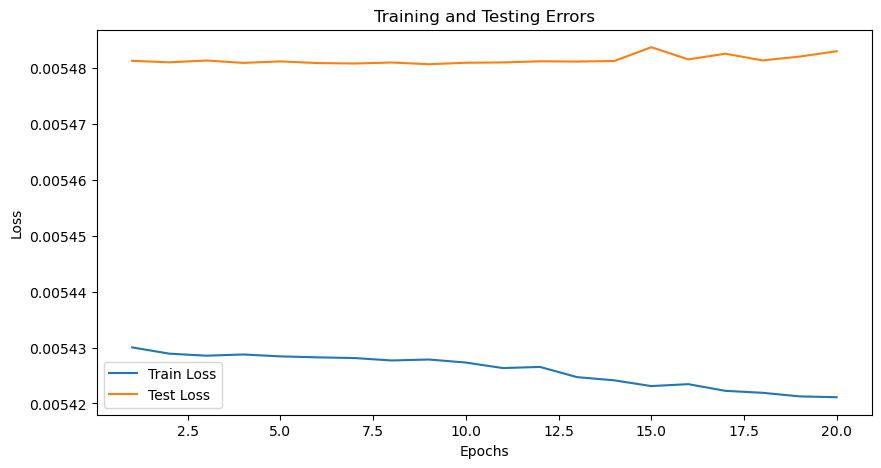

Final Results:
Test Accuracy: 6413.02%


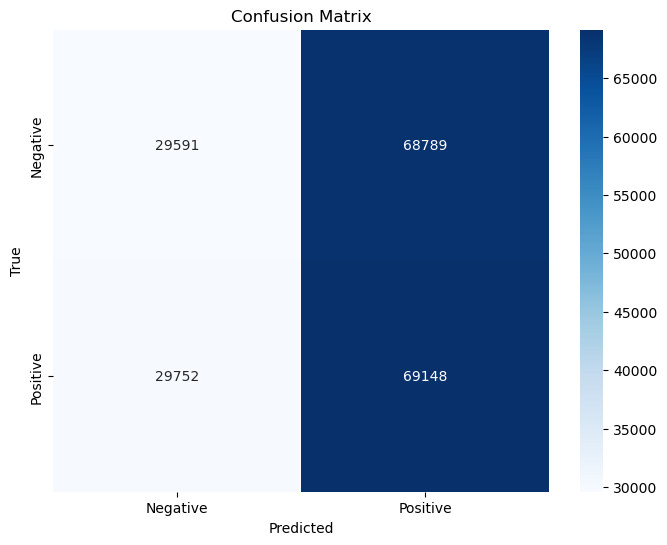

######################################################################################################################################################


In [10]:
# Load the GloVe embeddings
try:
    with open(path_for_glove, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    print('\033[92m' + 'Success to Load GloVe embeddings' + '\033[0m')
except FileNotFoundError:
    print('\033[91m' + 'Failed to Load GloVe embeddings' + '\033[0m')

# Create a dictionary to hold the GloVe embeddings
glove_embeddings = {}
for line in lines:
    values = line.split()
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    glove_embeddings[word] = vector

# Create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 100))

for word, index in vocab.items():
    if index < VOCAB_SIZE:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Create an embedding layer
embedding_layer = nn.Embedding(VOCAB_SIZE, 100)
embedding_layer.weight.data.copy_(torch.from_numpy(embedding_matrix))
embedding_layer.weight.requires_grad = False

# Print the embedding layer
print('\033[92m' + 'Embedding Layer:' + '\033[0m')
print(embedding_layer)
print("#" * 150)

# Create a new model with the GloVe embedding layer
class NN2HiddenLayersGloVe(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size, embedding_layer):
        super(NN2HiddenLayersGloVe, self).__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.embedding_layer = embedding_layer

        # Define the list to hold the RNN layers
        self.rnn_layers = nn.ModuleList()

        # Add the first RNN layer
        self.rnn_layers.append(nn.RNN(
            input_size=100,  # Update input_size to match the dimension of GloVe embeddings
            hidden_size=self.hidden_sizes[0],  # First hidden layer size
            batch_first=True,
            nonlinearity='tanh'
        ))

        # Add subsequent RNN layers with different sizes
        for i in range(1, len(self.hidden_sizes)):
            self.rnn_layers.append(nn.RNN(
                input_size=self.hidden_sizes[i - 1],  # Input size is the output size of the previous layer
                hidden_size=self.hidden_sizes[i],     # Current hidden layer size
                batch_first=True,
                nonlinearity='tanh'
            ))

        # Define the linear layer for classification
        self.classify = nn.Linear(self.hidden_sizes[-1], self.output_size)


    # Inside your model's forward method
    def forward(self, x):
        # Convert input tensor to Long type
        x = x.long()

        out = self.embedding_layer(x)
        for rnn_layer in self.rnn_layers:
            out, _ = rnn_layer(out)

        # Reshape the output tensor to match label size
        out = out[:, -1, :]  # Consider only the last time step
        out = self.classify(out)
        
        # Apply sigmoid activation function
        out = torch.sigmoid(out)
        
        return out


# Define the sizes of the hidden layers
hidden_sizes = [HIDDEN_SIZE2, HIDDEN_SIZE3]
# Initialize the model
model_4_hidden_layers_glove = NN2HiddenLayersGloVe(INPUT_SIZE, hidden_sizes, OUTPUT_SIZE, embedding_layer)
# Loss and optimizer binary cross entropy loss and Adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_4_hidden_layers_glove.parameters(), lr=LEARNING_RATE)
# Print the model architecture
print(model_4_hidden_layers_glove)
print("#" * 150)

# Train and evaluate the model
train_and_evaluate(model_4_hidden_layers_glove, train_loader, test_loader, optimizer, criterion, epochs=EPOCHS)
print("#" * 150)


# Training a BiDir LSTM neural network

Now do the same as the prvious section with a bi-directional LSTM.

Remember that the output of the LSTM should be connected to a small feed forward network to perform the actual classification.

Here again you can play with number of layers and the LSTM or the small network of the output. Show only the best result you got.

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

Are the results better than the previous section?




Epoch 1/7, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 64.13% Time: 1096.04 sec
Epoch 2/7, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 64.13% Time: 1113.73 sec
Epoch 3/7, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 63.77% Time: 1113.30 sec
Epoch 4/7, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 64.13% Time: 1112.71 sec
Epoch 5/7, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 63.77% Time: 1107.94 sec
Epoch 6/7, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 64.13% Time: 1107.95 sec
Epoch 7/7, Train Loss: 0.0054, Test Loss: 0.0055, Test Accuracy: 63.77% Time: 1106.20 sec


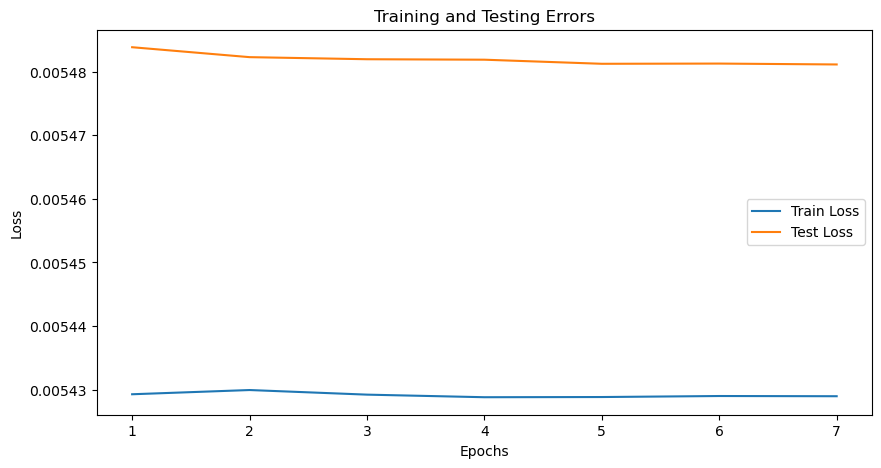

Final Results:
Test Accuracy: 6377.13%


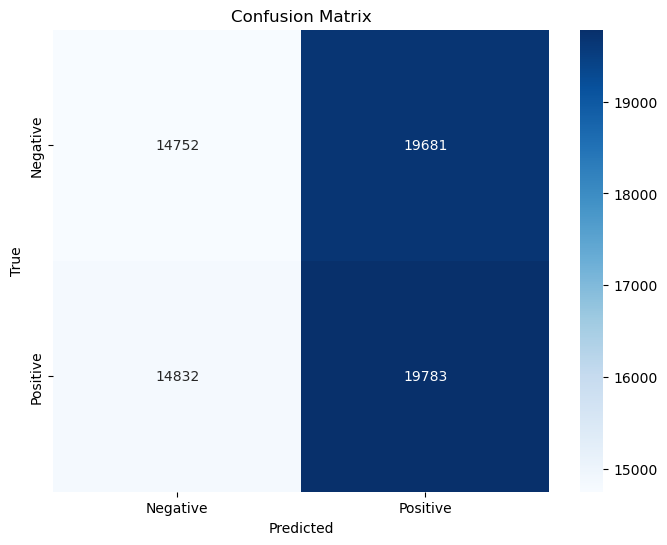

In [11]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 because of bidirectional LSTM

    def forward(self, x):
        # Convert input tensor to LongTensor
        x = x.long()
        embedded = self.embedding(x)
        lstm_out, _ = self.bilstm(embedded)
        out = self.fc(lstm_out[:, -1, :])  # Get the last output from the sequence
        out = torch.sigmoid(out)  # Apply sigmoid activation function
        return out

NUM_LAYERS = 2
HIDDEN_SIZE = 128

# Initialize the model
bilstm_model = BiLSTM(len(vocab), HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

# Loss and optimizer
bilstm_criterion = nn.BCELoss()
bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=LEARNING_RATE)

# Train and evaluate the model
train_and_evaluate(bilstm_model, train_loader, test_loader, bilstm_optimizer, bilstm_criterion, epochs=7)



Finally show 3 reviews from the test data with correct labales and 3 without, why do you think the network did not success on these examples?

In [12]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Set the model to evaluation mode
bilstm_model.eval()

# Lists to store correctly and incorrectly classified reviews
correctly_classified_reviews = []
incorrectly_classified_reviews = []

# Lists to store corresponding labels
correct_labels = []
incorrect_labels = []

# Lists to store corresponding predictions
correct_predictions = []
incorrect_predictions = []

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Make predictions
        outputs = bilstm_model(inputs)
        predictions = torch.sigmoid(outputs)

        # Convert predictions to binary values (0 or 1)
        binary_predictions = torch.round(predictions)

        # Compare predictions with labels
        for i in range(len(labels)):
            if binary_predictions[i] == labels[i]:
                # Correctly classified reviews
                correctly_classified_reviews.append(inputs[i])
                correct_labels.append(labels[i].item())
                correct_predictions.append(binary_predictions[i].item())
            else:
                # Incorrectly classified reviews
                incorrectly_classified_reviews.append(inputs[i])
                incorrect_labels.append(labels[i].item())
                incorrect_predictions.append(binary_predictions[i].item())

# Function to decode indices back to words
def decode_review(review_indices, vocab):
    inverse_vocab = {index: word for word, index in vocab.items()}
    return ' '.join([inverse_vocab[index.item()] for index in review_indices if index.item() != 0])

# Display three correctly classified reviews with their labels and predictions
print("Correctly Classified Reviews:")
for i in range(3):
    print("Review:", decode_review(correctly_classified_reviews[i], vocab))
    print("Actual Label:", correct_labels[i])
    print("Predicted Label:", correct_predictions[i])
    print()

# Display three incorrectly classified reviews with their labels and predictions
print("Incorrectly Classified Reviews:")
for i in range(3):
    print("Review:", decode_review(incorrectly_classified_reviews[i], vocab))
    print("Actual Label:", incorrect_labels[i])
    print("Predicted Label:", incorrect_predictions[i])
    print()


beep()
time.sleep(0.5)
beep()
time.sleep(0.5)
beep()

Correctly Classified Reviews:
Review: good fun political satire industry light character study well pacing bit slow comedy none really floor type funny except perhaps sound effects amusing moments big probably element quite right jack especially light romantic character political actually carry story heavy think one works quite well kind even light comedy better nothing <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA